In [1]:
import os
from collections import OrderedDict
import pandas as pd
from shapely import affinity
from shapely.geometry import MultiPoint
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

def df_to_od(df01):
    l = len(list(df01.itertuples()))
    ord_01 = OrderedDict()
    l = len(list(df01.itertuples()))
    for i in range(l):
        z = df01.loc[i]['Num']
        k = df01.loc[df01['Num'] == z]
        ord_01[list(k['Num'].iteritems())[0][1]]=(list(k['X'].iteritems())[0][1],list(k['Y'].iteritems())[0][1],list(k['Dist'].iteritems())[0][1])
    return ord_01

def od_to_df(od):
    #l = [[k,*od[k]] for k in od.keys()]
    l = []
    for k in od.keys():
        r = [k,od[k][0],od[k][1],od[k][2]]
        l.append(r)
    return pd.DataFrame.from_records(l,columns=['Num','X','Y','Dist'])

In [2]:
def chain_coords(path, original):
    df01 = pd.read_csv(os.path.join(path,original),sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
    df01['Dist'] = ''
    for f in [i for i in os.listdir(path) if '.csv' in i and original not in i]:
        od_01 = df_to_od(df01)
        print(f)
        df02 = pd.read_csv(os.path.join(path,f),sep=';', names=['Num','X','Y'],dtype={'Num':'str','X':'float','Y':'float'})
        df01_c = df01.loc[df01['Num'].isin(list(df02['Num']))].sort_values(by='Num')
        df02_c = df02.loc[df02['Num'].isin(list(df01['Num']))].sort_values(by='Num')
        mp01_c = MultiPoint([i[2:4] for i in df01_c.itertuples()])
        mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
        mp02_c = MultiPoint([i[2:4] for i in df02_c.itertuples()])
        x0 = (0,0,0)
        re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='BFGS')
        print(re.fun)
        x,y,angle = re.x
        mp02_c_moved =  mov(x,y,angle,mp02_c)
        ab = list(zip(mp01_c,mp02_c_moved))
        mp02_c_avg = MultiPoint([((i[0].x+i[1].x)/2,(i[0].y+i[1].y)/2) for i in ab])
        mp02_dist = [i[0].distance(i[1]) for i in ab]
        mp02_c_avg_dict = {k:v for k,v in zip(df02_c['Num'],list(zip(mp02_c_avg,mp02_dist)))}
        
        x,y,angle = re.x
        mp_moved = mov(x,y,angle,mp02)

        mp02_mov_dict = {k:v for k,v in zip(df02['Num'],list(zip(mp_moved,['']*len(mp_moved))))}
        for k in mp02_c_avg_dict.keys():
            mp02_mov_dict[k] = mp02_c_avg_dict[k]
        stag_02 = []
        for k in mp02_mov_dict.keys():
            row = [k,mp02_mov_dict[k][0].x,mp02_mov_dict[k][0].y,mp02_mov_dict[k][1]]
            stag_02.append(row)
        od_stag = OrderedDict({i[0]:(i[1],i[2],i[3]) for i in stag_02})
        for k in od_stag.keys():
            od_01[k] = od_stag[k]
        df01 = od_to_df(od_01)
    return df01

In [3]:
path = r'data/origin/ex'
original = '0000001.csv'

In [4]:
zz = chain_coords(path, original)
zz

0000002.csv
0.0019673786047450506
0000003.csv
0.0024583613656151723
0000004.csv
0.0018204321589599423
0000005.csv
186.2493982792377
0000006.csv
0.0004488540847271277
0000007.csv
0.0015863871758414457
0000008.csv
0.0021680195117478674
0000009.csv
0.0022470325657350503
0000010.csv
0.0028557457909972723
0000011.csv
0.0029030250530734003
0000012.csv
0.0030535081273165236
0000013.csv
0.0029496129506332547
0000014.csv
0.002725730616370711
0000015.csv
0.0038788157709509176
0000016.csv
0.0025618991205425953
0000017.csv
0.0020480552074321283
0000018.csv
0.0015462868747339953
0000019.csv
0.002521806999160571
0000020.csv
0.002856973207581171
0000021.csv
0.0017789494535176067
0000022.csv
0.0018868559990890856
0000023.csv
0.0016854183559349449
0000024.csv
0.002017940609132582
0000025.csv
0.0011056010255263288
0000026.csv
0.0013928575845996711
0000027.csv
0.0012527765750053209
0000028.csv
0.0009156260687340516
0000029.csv
0.0010021950687981638
0000030.csv
0.002107654333922032
0000031.csv
0.001981353

,Num,X,Y,Dist
0,6a,-32.440190,2.175777,3.81458e-05
1,7,-41.465722,1.645104,0.00055165
2,7b,-56.411152,1.329654,0.00013911
3,8,-70.667385,-5.257443,0.000111488
4,7a,-55.487757,-4.691142,0.000106032
5,6,-7.491881,-3.029261,0.00102095
6,4,28.701654,-1.783774,
7,3,40.871366,-2.022232,
8,1,-77.232177,0.000022,
9,2,66.775321,5.272296,


In [7]:
zz.to_csv(r'res.csv')


In [8]:
from shapely.geometry import MultiPoint

import matplotlib.pyplot as plt
%matplotlib inline  

def plp(z,n):
    for p in z:        
        x = [i.x for i in p.geoms]
        y = [i.y for i in p.geoms]
        plt.figure(n)
        plt.plot(x,y,'ro')
        plt.plot(x,y,'ro')
    plt.show()
    

In [9]:
mp01 = MultiPoint([i[2:4] for i in zz.itertuples()])

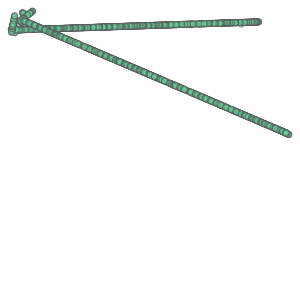

In [10]:
mp01

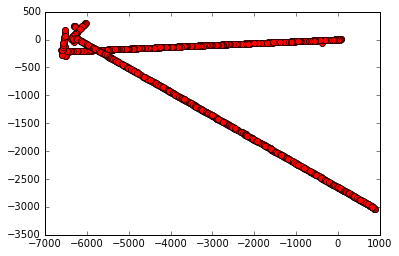

In [13]:
plp([mp01,],1)

gg

In [9]:
re.fun

NameError: name 're' is not defined

In [117]:
df01 = pd.read_csv(os.path.join(path,original),sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df01['Dist'] = ''

f = [i for i in os.listdir(path) if '.csv' in i and original not in i][0]
print(f)
df02 = pd.read_csv(os.path.join(path,f),sep=';', names=['Num','X','Y'],dtype={'Num':'str','X':'float','Y':'float'})
df01_c = df01.loc[df01['Num'].isin(list(df02['Num']))].sort_values(by='Num')
df02_c = df02.loc[df02['Num'].isin(list(df01['Num']))].sort_values(by='Num')
mp01_c = MultiPoint([i[2:4] for i in df01_c.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_c.itertuples()])
x0 = (0,0,0)
re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')
mp02_c_moved =  mov(*re.x,mp02_c)
ab = list(zip(mp01_c,mp02_c_moved))
mp02_c_avg = MultiPoint([((i[0].x+i[1].x)/2,(i[0].y+i[1].y)/2) for i in ab])
mp02_dist = [i[0].distance(i[1]) for i in ab]
mp02_c_avg_dict = {k:v for k,v in zip(df02_c['Num'],list(zip(mp02_c_avg,mp02_dist)))}
print(re)
mp_moved = mov(*re.x,mp02)

mp02_mov_dict = {k:v for k,v in zip(df02['Num'],list(zip(mp_moved,['']*len(mp_moved))))}
print(mp02_mov_dict['605'][0].x)
for k in mp02_c_avg_dict.keys():
    mp02_mov_dict[k] = mp02_c_avg_dict[k]
stag_02 = []
for k in mp02_mov_dict.keys():
    row = [k,mp02_mov_dict[k][0].x,mp02_mov_dict[k][0].y,mp02_mov_dict[k][1]]
    stag_02.append(row)
stag_df = pd.DataFrame.from_records(stag_02,columns=['Num','X','Y','Dist'])
zz = pd.concat([df01,stag_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()

104.csv
     fun: 0.002081701982871198
     jac: array([   3.7404325 ,    2.57947205, -439.46588063,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 424
     nit: 71
    njev: 71
  status: 0
 success: True
       x: array([ -267.26849401,  2441.26995037,     9.99506175])
-14414.777335718443


In [19]:
zz

,Num,X,Y,Dist
0,597,-14227.175700,-336.142800,
1,596,-14205.796800,-321.824000,
2,598,-14252.269027,-340.045867,0.00036358
3,599,-14274.392002,-354.625009,1.77909e-05
4,600,-14299.916054,-358.684141,0.000840608
5,601,-14321.164081,-372.931802,0.000199619
6,602,-14346.579496,-376.987409,0.000264754
7,603,-14367.718779,-391.157282,0.000729077
8,595,-14180.551200,-317.862700,
9,593,-14133.887400,-299.583600,


In [81]:
df01

,Num,X,Y,Dist
0,597,-14227.1757,-336.1428,
1,596,-14205.7968,-321.8240,
2,598,-14252.2691,-340.0457,
3,599,-14274.3920,-354.6250,
4,600,-14299.9163,-358.6838,
5,601,-14321.1641,-372.9319,
6,602,-14346.5794,-376.9875,
7,603,-14367.7186,-391.1576,
8,595,-14180.5512,-317.8627,
9,593,-14133.8874,-299.5836,


Без усреднения: